In [1]:
'''
!git clone https://github.com/rajanlab/CURBD.git
import os 
os.chdir('/content/CURBD/')
'''

"\n!git clone https://github.com/rajanlab/CURBD.git\nimport os \nos.chdir('/content/CURBD/')\n"

In [4]:
import numpy as np
import numpy.random as npr
import pylab
import curbd
import math
import matplotlib.pyplot as plt
#%matplotlib
import seaborn as sns


import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import torch.optim as optim
import pickle 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


c:\Users\Andrew\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
'''sim = curbd.threeRegionSim(number_units=100,
                           ga=1.8,
                           gb=1.5,
                           gc=1.5,
                           tau=0.1,
                           fracInterReg=0.05,
                           ampInterReg=0.02,
                           fracExternal=0.5,
                           ampInB=1,
                           ampInC=-1,
                           dtData=0.01,
                           T=10,
                           leadTime=2,
                           bumpStd=0.2,
                           )'''

'''with open("simulation.pkl", "wb") as f:
    pickle.dump(sim, f)'''

'sim = curbd.threeRegionSim(number_units=100,\n                           ga=1.8,\n                           gb=1.5,\n                           gc=1.5,\n                           tau=0.1,\n                           fracInterReg=0.05,\n                           ampInterReg=0.02,\n                           fracExternal=0.5,\n                           ampInB=1,\n                           ampInC=-1,\n                           dtData=0.01,\n                           T=10,\n                           leadTime=2,\n                           bumpStd=0.2,\n                           )'

In [45]:
sim = torch.load("REAL_SIM.pt")

In [46]:
#three regions with each region having 100 units and 1201 time series data
activity = np.concatenate((sim['Ra'], sim['Rb'], sim['Rc']), 0) #300 x 1201
activity = activity[:,:300]

Na = sim['params']['Na']
Nb = sim['params']['Nb']
Nc = sim['params']['Nc']

regions = []
regions.append(['Region A', np.arange(0, Na)])
regions.append(['Region B', np.arange(Na, Na + Nb)])
regions.append(['Region C', np.arange(Na + Nb, Na + Nb + Nc)])
regions = np.array(regions, dtype=object)

# Initializing the parameters 

In [47]:
dtData=sim['params']['dtData'] # time step of training data
# dtData=None
dtFactor=5 # number of interpolation steps for RNN 
regions=regions # number of regions and names of the regions
# tauRNN=2*sim['params']['tau']/2 # decay constant of RNN 
tauRNN=50 # decay constant of RNN 

g=1.5 # instability constant 
tauWN=0.1 #decay constant on filtered white noise inputs
ampInWN=0.01 #input amplitude of filtered white noise 
resetPoints=None
plotStatus=True
regions=None


In [48]:
if dtData is None: #0.01
    print('dtData not specified. Defaulting to 1.');
    dtData = 1;
if resetPoints is None:
    resetPoints = [0, ]
if regions is None:
    regions = {}

In [49]:
number_units = activity.shape[0] #300 -- the total number of units 
number_learn = activity.shape[0] #300
dtRNN = dtData / float(dtFactor) # 0.01/5=0.002

In [50]:
learnList = npr.permutation(number_units) #randomize the units
iTarget = learnList[:number_learn]
iNonTarget = learnList[number_learn:] # []

tData = dtData*np.arange(activity.shape[1]) #   [0, 0.01, 0.02 ....,12.01] #1201 input time steps 
tRNN = np.arange(0, tData[-1] + dtRNN, dtRNN) # [0, 0.002, 0.004 ...., 12.01] #6000 rnn time steps

# External Input to RNN

In [51]:
ampWN = math.sqrt(tauWN/dtRNN) # (0.1/0.002)
iWN = ampWN * npr.randn(number_units, len(tRNN)) #gaussian noise ? #300x6001
inputWN = np.ones((number_units, len(tRNN))) #300x6001
# print("inputWN : ",inputWN)
for tt in range(1, len(tRNN)):
    inputWN[:, tt] = iWN[:, tt] + (inputWN[:, tt - 1] - iWN[:, tt])*np.exp(- (dtRNN / tauWN)) # solve the above differential equation 
inputWN = ampInWN * inputWN # external input h(t)


# Set up target training data

In [52]:
Adata = activity.copy()
Adata = Adata/Adata.max()
Adata = np.minimum(Adata, 0.999) # elementwise minimum 
Adata = np.maximum(Adata, -0.999) # elementwise max
print (Adata.shape)

(300, 300)


# Model Definition

In [82]:
import sys 

class CTRNN(nn.Module):
    """Continuous-time RNN."""
    def __init__(self,
                 g,
                 tauRNN,
                 dtRNN,
                 input_units,
                 output_units,
                 dt=None,
                 **kwargs):
      
        super(CTRNN,self).__init__()

        self.tauRNN = tauRNN
        self.dtRNN=dtRNN
        self.g=g
        self.input_units=input_units
        self.output_units=output_units
        
        
#        print(self.J)
       
        self.J = nn.Parameter((self.g * torch.Tensor(npr.randn(input_units, output_units) / math.sqrt(output_units))))

        #print(torch.numel(mask[0:100, 100:]))
      
    def forward(self, hidden, noise=None):
        if(noise is not None):
           noise = torch.zeros_like(noise)
        
        """Propogate input through the network."""
        
        # When calculating fixed points: We want to find _hidden_ vectors such that -hidden + JR equals the 0 vector.
        activation = torch.tanh(torch.Tensor(hidden))
        JR = torch.matmul(self.J, activation).reshape((self.input_units,1))
        

        new_hidden = hidden + self.dtRNN*(-hidden + JR)/self.tauRNN
        return activation, new_hidden


In [83]:
rnn_model = CTRNN(g=g,
                  tauRNN=tauRNN,
                  dtRNN=dtRNN,
                  input_units=number_units,
                  output_units=number_units,
                  )

In [57]:
'''
g = 1.5
rnn_model = CTRNN(g=g,
                  tauRNN=tauRNN,
                  dtRNN=dtRNN,
                  input_units=number_units,
                  output_units=number_units)

rnn_model.to(device)
rnn_model.load_state_dict(torch.load("REAL_WEIGHTS_NONOISE.pt"))
weights_initial = rnn_model.J.detach().cpu().numpy().copy()
'''

'\ng = 1.5\nrnn_model = CTRNN(g=g,\n                  tauRNN=tauRNN,\n                  dtRNN=dtRNN,\n                  input_units=number_units,\n                  output_units=number_units)\n\nrnn_model.to(device)\nrnn_model.load_state_dict(torch.load("REAL_WEIGHTS_NONOISE.pt"))\nweights_initial = rnn_model.J.detach().cpu().numpy().copy()\n'

In [15]:
def run_trajectory(model, starting_point, iterations=100):
    trajectory = []
    trajectory.append(starting_point)
    for iteration in range(iterations):
        activation, new_hidden = model(starting_point)
        trajectory.append(new_hidden)
        starting_point = new_hidden
    
    return torch.cat(trajectory, dim=1).detach().numpy().T

In [16]:
trajectory = run_trajectory(rnn_model, fixed_points[0], iterations=10000)

NameError: name 'fixed_points' is not defined

In [ ]:
trajectory.shape

In [17]:
fixed_points = torch.load("REAL_FIXED_POINTS.pt")
random_point = (torch.rand_like(fixed_points[0])-0.5) * 10

In [ ]:
'''
with torch.no_grad():
    print(fixed_points[0] - rnn_model(fixed_points[0])[1]  )
'''

In [85]:
import numpy as np
from sklearn.decomposition import PCA
import pickle

pca = PCA(n_components=3)
pca2 = PCA(n_components=2)

In [ ]:
pca.fit()

In [ ]:
fixed_points = torch.cat(fixed_points,)

In [ ]:
list(fixed_points.reshape(10,300)[:,0])

In [ ]:
fig, ax = plt.subplots()

x = pca2.fit_transform(fixed_points.reshape(10,300))[:,0]
y = pca2.fit_transform(fixed_points.reshape(10,300))[:,1]
ax.scatter(x, y)

for i in range(len(x)):
    ax.annotate(i, (x[i], y[i]))


In [ ]:
perturbed_pt_1 = fixed_points[0] + torch.rand_like(fixed_points[0])*0.01

In [76]:
pt_20_20_20 = torch.Tensor(pca.inverse_transform((20,20,20))).unsqueeze(1)
pt_100_100_100 = torch.Tensor(pca.inverse_transform((100,100,100))).unsqueeze(1)

In [86]:
random_trajectory = run_trajectory(rnn_model, random_point, iterations=10000)
pca.fit(random_trajectory)

PCA(n_components=3)

In [88]:
with open("PCA.pkl", 'rb') as f:
    pca = pickle.load(f)

In [92]:
def get_random_points(num_points=100, low=-100, high=100):
    return (torch.rand((num_points, 300)) - 0.5) * 200



In [103]:
def get_all_trajectories(model, candidate_points, iterations=30000):
    all_trajectories = []
    for starting_point in candidate_points:
        
        trajectory = run_trajectory(model=model, starting_point=starting_point.unsqueeze(1), iterations=iterations)
        all_trajectories.append(trajectory)
    
    return all_trajectories

In [185]:
points = get_random_points(num_points=5)
all_trajectories = get_all_trajectories(rnn_model, points, iterations=10000)


In [186]:
fig = plt.figure()
ax = plt.axes(projection='3d')

for i,trajectory in enumerate(all_trajectories):
    # fig = plt.figure()
    # ax = plt.axes(projection='3d')
    
    print(pca.transform(trajectory).shape)
    transformed = pca.transform(trajectory)
    ax.scatter3D(transformed[:,0], transformed[:,1], transformed[:,2], c=np.arange(0,transformed[:,0].shape[0]), cmap='Reds', label='trajectory near fixed point');
    print("test")


# ax.legend()
plt.show()


(10001, 3)
test
(10001, 3)
test
(10001, 3)
test
(10001, 3)
test
(10001, 3)
test


In [ ]:

fig = plt.figure()
ax = plt.axes(projection='3d')


#ax.scatter3D(x, y, z, c=np.arange(0,x.shape[0]), cmap='Greens');
ax.scatter3D(x_1, y_1, z_1, c=np.arange(0,x_1.shape[0]), cmap='Reds', label='trajectory near fixed point');
#ax.scatter3D(x_2, y_2, z_2, c=np.arange(0,x_1.shape[0]), cmap='Blues', label='trajectory at random point');
#ax.scatter3D(x_3, y_3, z_3, c=np.arange(0,x_1.shape[0]), cmap='Greens', label='trajectory fixed point');
#ax.scatter3D(x_4, y_4, z_4, c=np.arange(0,x_1.shape[0]), cmap='plasma', label='trajectory fixed point');
ax.scatter3D(x_5, y_5, z_5, c=np.arange(0,x_5.shape[0]), cmap='Reds', label='trajectory fixed 5 point');


ax.legend()
plt.show


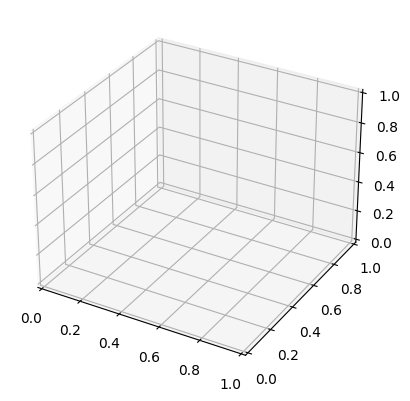

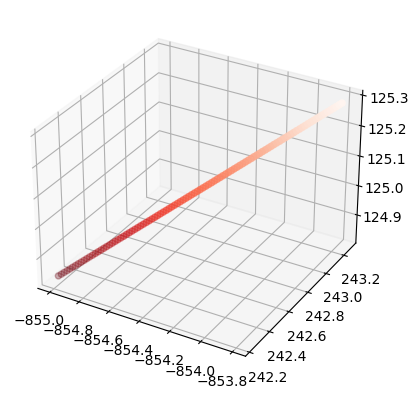

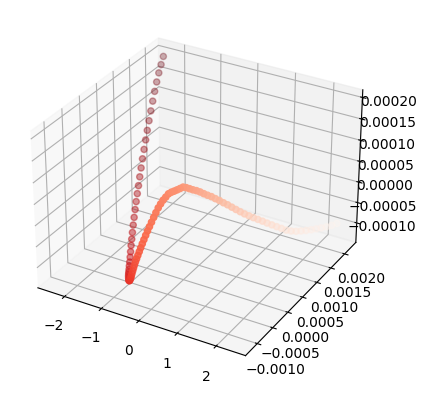

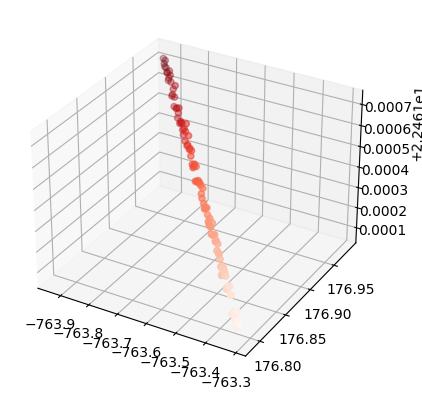

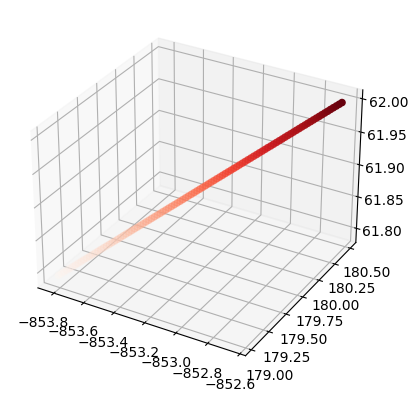

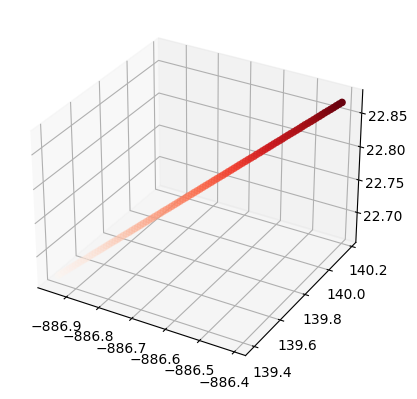

In [154]:
def plot_fn(plt,ax,trajectory,n_components=3):

    if n_components== 3:
        x = trajectory[:,0]
        y = trajectory[:,1]
        z = trajectory[:,2]
        ax.scatter3D(x, y, z, c=np.arange(0,x.shape[0]), cmap='Reds');

    if n_components== 2:
        x = trajectory[:,0]
        y = trajectory[:,1]
        ax.scatter(x, y, c=np.arange(0,x.shape[0]), cmap='Reds');


def plot_trajectories(trajectories, n_components=3):
    fitted = []
    pca = PCA(n_components=n_components)

    pca.fit(trajectories[1])
    #first_fitted = pca.transform(trajectories[0])
    # fitted = pca.fit(trajectories)
    # first_fitted= pca.transform(trajectories[0])
    #fitted.append(first_fitted)

    fig = plt.figure()
    if n_components==3:
        ax = plt.axes(projection='3d')
    else :
        ax= plt.axes()

    #plot_fn(plt,ax,first_fitted,n_components)

    for i, trajectory_data in enumerate(trajectories):
        
        
        fitted_trajectory = pca.transform(trajectory_data)
        # fitted.append(fitted_trajectory)

        fig = plt.figure()
        if n_components==3:
            ax = plt.axes(projection='3d')
        else :
            ax= plt.axes()

        plot_fn(plt,ax,fitted_trajectory,n_components)

    return fig

f = plot_trajectories(all_trajectories, n_components=3 )



<function matplotlib.pyplot.show(close=None, block=None)>

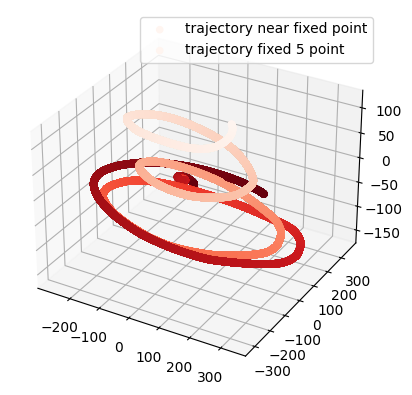

In [155]:
fig = plt.figure()


ax = plt.axes(projection='3d')

#ax.scatter3D(x, y, z, c=np.arange(0,x.shape[0]), cmap='Greens');
ax.scatter3D(x_1, y_1, z_1, c=np.arange(0,x_1.shape[0]), cmap='Reds', label='trajectory near fixed point');
#ax.scatter3D(x_2, y_2, z_2, c=np.arange(0,x_1.shape[0]), cmap='Blues', label='trajectory at random point');
#ax.scatter3D(x_3, y_3, z_3, c=np.arange(0,x_1.shape[0]), cmap='Greens', label='trajectory fixed point');
#ax.scatter3D(x_4, y_4, z_4, c=np.arange(0,x_1.shape[0]), cmap='plasma', label='trajectory fixed point');
ax.scatter3D(x_5, y_5, z_5, c=np.arange(0,x_5.shape[0]), cmap='Reds', label='trajectory fixed 5 point');


ax.legend()
plt.show()

In [166]:
x_1.shape

(10001,)

In [107]:
all_trajectories[0].shape

(101, 300)

In [97]:
points.shape

torch.Size([100, 300])

In [75]:
totorch.save(trajectory_5, "10ktrajectory.pt")

In [83]:
# Run a trajectory starting at the 9th fixed point for 100 iterations
random_point = torch.rand_like(fixed_points[0])
'''trajectory_1 = run_trajectory(rnn_model, fixed_points[0], iterations=10000)
trajectory_2 = run_trajectory(rnn_model, random_point, iterations=10000)
trajectory_3 = run_trajectory(rnn_model, perturbed_pt_1, iterations=10000)
trajectory_4 = run_trajectory(rnn_model, pt_20_20_20, iterations=10000)
'''
trajectory_5 = run_trajectory(rnn_model, pt_100_100_100, iterations=100000)


fitted_1 = pca.transform(trajectory_1)
fitted_2 = pca.transform(trajectory_2)
fitted_3 = pca.transform(trajectory_3)
fitted_4 = pca.transform(trajectory_4)
fitted_5 = pca.transform(trajectory_5)

fitted2_1 = pca2.fit_transform(trajectory_1)
fitted2_2 = pca2.transform(trajectory_2)
fitted2_3 = pca2.transform(trajectory_3)
fitted2_4 = pca2.transform(trajectory_4)

x_1 = fitted_1[:,0]
y_1 = fitted_1[:,1]
z_1 = fitted_1[:,2]

x_2 = fitted_2[:,0]
y_2 = fitted_2[:,1]
z_2 = fitted_2[:,2]

x_3 = fitted_3[:,0]
y_3 = fitted_3[:,1]
z_3 = fitted_3[:,2]

x_4 = fitted_4[:,0]
y_4 = fitted_4[:,1]
z_4 = fitted_4[:,2]

x_5 = fitted_5[:,0]
y_5 = fitted_5[:,1]
z_5 = fitted_5[:,2]

<function matplotlib.pyplot.show(close=None, block=None)>

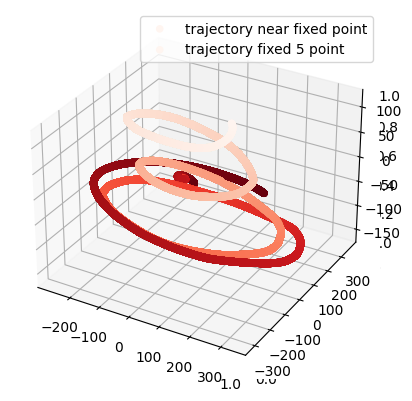

In [84]:

fig = plt.figure()
ax = plt.axes(projection='3d')

ax = plt.axes(projection='3d')

#ax.scatter3D(x, y, z, c=np.arange(0,x.shape[0]), cmap='Greens');
ax.scatter3D(x_1, y_1, z_1, c=np.arange(0,x_1.shape[0]), cmap='Reds', label='trajectory near fixed point');
#ax.scatter3D(x_2, y_2, z_2, c=np.arange(0,x_1.shape[0]), cmap='Blues', label='trajectory at random point');
#ax.scatter3D(x_3, y_3, z_3, c=np.arange(0,x_1.shape[0]), cmap='Greens', label='trajectory fixed point');
#ax.scatter3D(x_4, y_4, z_4, c=np.arange(0,x_1.shape[0]), cmap='plasma', label='trajectory fixed point');
ax.scatter3D(x_5, y_5, z_5, c=np.arange(0,x_5.shape[0]), cmap='Reds', label='trajectory fixed 5 point');


ax.legend()
plt.show


In [80]:
x_1

array([-7.748367 , -7.748349 , -7.7483325, ..., 27.102102 , 27.118223 ,
       27.134243 ], dtype=float32)

In [ ]:

plt.plot(fitted2_1[:,0],fitted2_1[:,1], label='starting very close to fixed point') 
plt.plot(fitted2_2[:,0],fitted2_2[:,1], label='starting at a random point') 
plt.plot(fitted2_3[:,0],fitted2_3[:,1], label='starting sort of close to a fixed point') 
plt.plot(fitted2_4[:,0],fitted2_4[:,1], label='starting at 20,20,20 in the 3d space') 

#plt.gca().set_aspect("equal") 
plt.legend()
plt.show()


In [ ]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')

ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=np.arange(0,xdata.shape[0]), cmap='Greens');

In [59]:
calculate_lyapunov_exponents

TypeError: calculate_lyapunov_exponents() missing 1 required positional argument: 'model'

# Training

In [87]:
optimizer = optim.Adam(rnn_model.parameters(), lr=1e-1, weight_decay=1e-3)
criterion = nn.MSELoss()
loss_list = []
# RNN = np.zeros((number_units, len(tRNN)))
saved_LEs = []

for epoch in range(300):
    if(epoch % 60 == 0):
       saved_LEs.append(calculate_lyapunov_exponents(rnn_model, iterations=5))
       
    tLearn = 0 
    iLearn = 0 
    loss = 0

    hidden = torch.tanh(torch.Tensor(Adata[:, 0, np.newaxis])).to(device)
    # RNN[:, 0, np.newaxis] = hidden.detach().cpu().numpy()
    # output = hidden
    for i in range(1,len(tRNN)):
        tLearn += dtRNN
        
        # RNN[:, i, np.newaxis] = output.detach().cpu().numpy()

        output, hidden = rnn_model(hidden,
                                  torch.Tensor(inputWN[:, i, np.newaxis]).to(device))
        

        if tLearn >= dtData:
          tLearn=0
          running_loss = criterion(output,
                                   torch.Tensor(Adata[:, iLearn ,np.newaxis]).to(device))
          iLearn = iLearn + 1 
          loss+=running_loss
    optimizer.zero_grad()   # zero the gradient buffers
    if (epoch)%1 ==0 :
      print (f"Epoch is {epoch}, loss is {loss}")
    loss.backward()

    optimizer.step()    # Does the update
    loss_list.append(loss)

Epoch is 0, loss is 148.22915649414062
Epoch is 1, loss is 102.53456115722656
Epoch is 2, loss is 80.65074157714844
Epoch is 3, loss is 69.57057189941406
Epoch is 4, loss is 63.43358612060547
Epoch is 5, loss is 59.14286804199219
Epoch is 6, loss is 55.688594818115234
Epoch is 7, loss is 52.949188232421875
Epoch is 8, loss is 50.8164176940918
Epoch is 9, loss is 48.98896789550781
Epoch is 10, loss is 47.28705596923828
Epoch is 11, loss is 45.738155364990234
Epoch is 12, loss is 44.33678436279297
Epoch is 13, loss is 43.018672943115234
Epoch is 14, loss is 41.81735610961914
Epoch is 15, loss is 40.765892028808594
Epoch is 16, loss is 39.81693649291992
Epoch is 17, loss is 38.908470153808594
Epoch is 18, loss is 38.030216217041016
Epoch is 19, loss is 37.20586395263672
Epoch is 20, loss is 36.43356704711914
Epoch is 21, loss is 35.71246337890625
Epoch is 22, loss is 35.044410705566406
Epoch is 23, loss is 34.4192008972168
Epoch is 24, loss is 33.82687759399414
Epoch is 25, loss is 33.268

KeyboardInterrupt: 

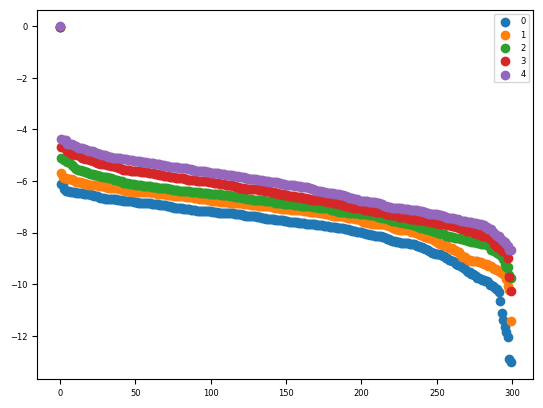

In [68]:
len(saved_LEs)

for i, LEs in enumerate(saved_LEs):
    plt.scatter(np.arange(300), torch.sort(LEs, dim=0, descending=True).values.detach().numpy(), label=f'{i}')

plt.legend()
plt.show()

In [78]:
torch.max(saved_LEs[4])

tensor(-0.0034)

In [103]:
rnn_model.J[:100,100:]

tensor([[-0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000,
          0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  0.0000,
         -0.0000, -0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000, -0.0000,
         -0.0000,  0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000,
         -0.0000, -0.0739, -0.5839, -0.0042,  0.0000,  0.0000,  0.0594,  0.0000,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         -0.0000,  0.0000,  0.0000, -0.7376, -0.0000, -0.0000, -0.0000, -0.0000,
          0.0000, -0.0000,  0.6605,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  0.3502,  0.0000,
         -0.0000,  0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0108,
          0.0000,  0.6665, -

# Calculate Lyapunov Exponents


In [18]:
torch.linalg.qr(torch.eye(300))

torch.return_types.linalg_qr(
Q=tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]]),
R=tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]]))

In [30]:
from torch.autograd.functional import jacobian

In [31]:
rnn_model.load_state_dict(torch.load("REAL_WEIGHTS_NONOISE.pt"))

<All keys matched successfully>

In [71]:
hidden = torch.zeros(300,1)
hidden = torch.Tensor(Adata[:, 0, np.newaxis])

Q = torch.reshape(torch.eye(100),  (1,100,100)).to('cpu')

rnn_model.eval()
total_exponents = torch.zeros(100,1)


for x in range(3):
    for y in range(3):
        
      for i in range(50):
          output, new_hidden = rnn_model(hidden)
          hidden = new_hidden
          jac = jacobian(rnn_model, hidden)[1].squeeze()
          
          if(x == 0 and y == 0):
            restricted_jacobian = jac[:100,:100]
          elif(x == 0 and y == 1):
             restricted_jacobian = jac[:100,100:200]
          elif(x == 0 and y == 2):
             restricted_jacobian = jac[:100,200:]
          elif(x == 1 and y == 0):
            restricted_jacobian = jac[100:200,:100]
          elif(x == 1 and y == 1):
             restricted_jacobian = jac[100:200,100:200]
          elif(x == 1 and y == 2):
             restricted_jacobian = jac[100:200,200:]
          elif(x == 2 and y == 0):
            restricted_jacobian = jac[200:,:100]
          elif(x == 2 and y == 1):
             restricted_jacobian = jac[200:,100:200]
          elif(x == 2 and y == 2):
             restricted_jacobian = jac[200:,200:]
          
            
          Q = torch.matmul(restricted_jacobian, Q)
          
          upper_triangular_matrix = torch.linalg.qr(Q).R # 100x100
        # print(upper_triangular_matrix.shape)
      
      #   s = torch.diag_embed(torch.sign(torch.diagonal(upper_triangular_matrix)))#extract sign of each leading r value
      #   print(s.shape)
      #   Q = torch.matmul(Q.squeeze(), s.squeeze())
      #   r = torch.diagonal(torch.matmul(s.squeeze(), upper_triangular_matrix)) #return positive r values and corresponding vectors
      #   print(Q.shape)
        
          total_exponents += torch.log(abs(torch.diagonal(upper_triangular_matrix)))
          #print(torch.log(abs(torch.diagonal(upper_triangular_matrix))))

      print((x,y), total_exponents)


(0, 0) tensor([[ 2.7160e-02],
        [-3.2699e+02],
        [-2.9610e+02],
        [-4.5172e+02],
        [-4.0226e+02],
        [-3.3225e+02],
        [-3.1118e+02],
        [-2.8158e+02],
        [-3.7314e+02],
        [-3.3476e+02],
        [-3.3494e+02],
        [-3.2919e+02],
        [-3.4720e+02],
        [-3.1082e+02],
        [-2.9090e+02],
        [-4.6077e+02],
        [-3.6313e+02],
        [-2.9139e+02],
        [-2.8552e+02],
        [-3.2566e+02],
        [-3.0540e+02],
        [-4.3370e+02],
        [-5.1290e+02],
        [-3.9964e+02],
        [-2.6459e+02],
        [-3.1139e+02],
        [-3.0066e+02],
        [-3.2731e+02],
        [-2.5530e+02],
        [-2.5603e+02],
        [-2.8020e+02],
        [-3.2265e+02],
        [-3.3353e+02],
        [-3.3761e+02],
        [-3.7013e+02],
        [-3.2174e+02],
        [-3.1036e+02],
        [-2.8801e+02],
        [-3.7918e+02],
        [-3.0154e+02],
        [-2.9306e+02],
        [-4.1358e+02],
        [-2.9288e+02],
    

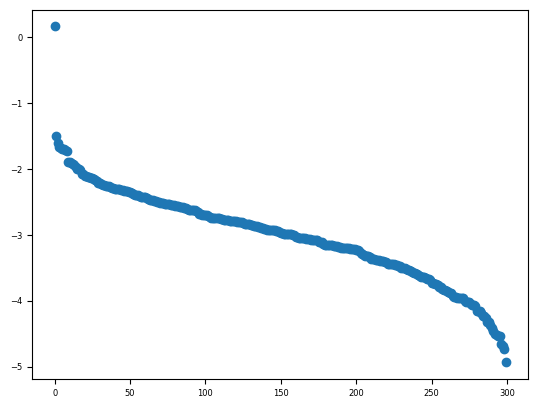

In [40]:
plt.scatter(np.arange(300), torch.sort(total_exponents, dim=0, descending=True).values.detach().numpy())

In [41]:
def calculate_lyapunov_exponents(model, iterations=2000):
    hidden = torch.zeros(300,1)
    hidden = torch.Tensor(Adata[:, 0, np.newaxis])

    Q = torch.reshape(torch.eye(300),  (1,300,300)).to('cpu')

    model.eval()
    total_exponents = torch.zeros(300,1)
    for i in range(iterations):
        output, new_hidden = model(hidden)
        hidden = new_hidden
        jac = jacobian(model, hidden)[1].squeeze()
        
        Q = torch.matmul(jac, Q)
        
        upper_triangular_matrix = torch.linalg.qr(Q).R
   
        total_exponents += torch.log(abs(torch.diagonal(upper_triangular_matrix)))

    total_exponents /= iterations
    return total_exponents

In [38]:
hidden = torch.zeros(300,1)
hidden = torch.Tensor(Adata[:, 0, np.newaxis])

Q = torch.reshape(torch.eye(300),  (1,300,300)).to('cpu')

rnn_model.eval()
total_exponents = torch.zeros(300,1)
iterations = 2000
for i in range(iterations):
    output, new_hidden = rnn_model(hidden)
    hidden = new_hidden
    jac = jacobian(rnn_model, hidden)[1].squeeze()
    
    Q = torch.matmul(jac, Q)
    
    upper_triangular_matrix = torch.linalg.qr(Q).R
   # print(upper_triangular_matrix.shape)
 
 #   s = torch.diag_embed(torch.sign(torch.diagonal(upper_triangular_matrix)))#extract sign of each leading r value
 #   print(s.shape)
 #   Q = torch.matmul(Q.squeeze(), s.squeeze())
 #   r = torch.diagonal(torch.matmul(s.squeeze(), upper_triangular_matrix)) #return positive r values and corresponding vectors
 #   print(Q.shape)
    total_exponents += torch.log(abs(torch.diagonal(upper_triangular_matrix)))

total_exponents /= iterations
print(total_exponents)

tensor([[ 0.1586],
        [-2.2505],
        [-2.7982],
        [-2.6249],
        [-3.6356],
        [-3.3192],
        [-2.1042],
        [-2.1742],
        [-2.1442],
        [-3.4155],
        [-2.1450],
        [-2.8344],
        [-2.4814],
        [-2.8670],
        [-1.9773],
        [-2.9107],
        [-2.3256],
        [-2.3362],
        [-1.5081],
        [-2.2226],
        [-2.5367],
        [-3.3191],
        [-2.4184],
        [-4.3286],
        [-2.0175],
        [-2.5159],
        [-2.1262],
        [-2.4253],
        [-2.5377],
        [-2.3012],
        [-2.1183],
        [-1.6950],
        [-3.2762],
        [-3.2176],
        [-2.5539],
        [-3.9532],
        [-3.0459],
        [-2.2453],
        [-2.2313],
        [-3.1988],
        [-2.0076],
        [-2.9231],
        [-2.1599],
        [-2.7917],
        [-2.3584],
        [-2.3409],
        [-2.6987],
        [-2.0847],
        [-3.1131],
        [-2.8545],
        [-3.1450],
        [-3.0642],
        [-2.

In [ ]:
torch.save(rnn_model.state_dict(), "REAL_WEIGHTS_NONOISE.pt")

In [ ]:
torch.save(sim, "REAL_SIM.pt")

# Save Weights

In [ ]:
state = {
        'epoch': epoch,
        'state_dict': rnn_model.state_dict(),
        'optimizer': optimizer.state_dict(),
}

savepath='checkpoint.t7'

torch.save(state,savepath)


In [88]:
del rnn_model

rnn_model = CTRNN(g=g,
                  tauRNN=tauWN,
                  dtRNN=dtRNN,
                  input_units=number_units,
                  output_units=number_units).to(device)


# Validation

In [88]:
#checkpoint = torch.load("CTRNN_weights1.pt")
#rnn_model.load_state_dict(checkpoint)
#optimizer.load_state_dict(checkpoint['optimizer'])
#epoch = checkpoint['epoch']


def validate(model,tRNN):
    
    with torch.no_grad():
      hidden = torch.tanh(torch.Tensor(Adata[:, 0, np.newaxis])).to(device)
      tLearn = 0 
      iLearn = 0 
      predicted=[]
      gt=[]

      for i in range(1,len(tRNN)):
          tLearn += dtRNN
          
          output, hidden = rnn_model(hidden,
                                     torch.Tensor(inputWN[:, i, np.newaxis]).to(device))
          

          if tLearn >= dtData:
            tLearn=0
            predicted.append(torch.tensor(output).detach().cpu().numpy())
            gt.append(torch.Tensor(Adata[:, iLearn ,np.newaxis]).to(device).detach().cpu().numpy())
            iLearn = iLearn + 1 
            
                
    return predicted, gt

preds,actual = validate(rnn_model,tRNN=tRNN)

C:\Users\Andrew\AppData\Local\Temp\ipykernel_6332\2054434804.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted.append(torch.tensor(output).detach().cpu().numpy())


# Plot the activity of a neuron 

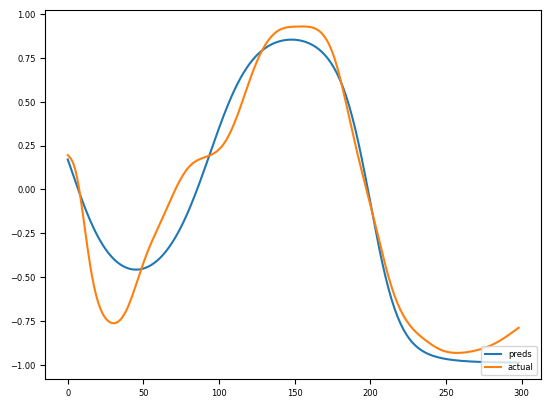

In [89]:
neuron_id = 1
x = list(range(len(preds)))
p=[pred[neuron_id][0] for pred in preds]
a=[act[neuron_id][0] for act in actual]


plt.plot(p)
plt.plot(a)
plt.legend(["preds", "actual"], loc ="lower right")
plt.show()

# Plot the average activity of regions

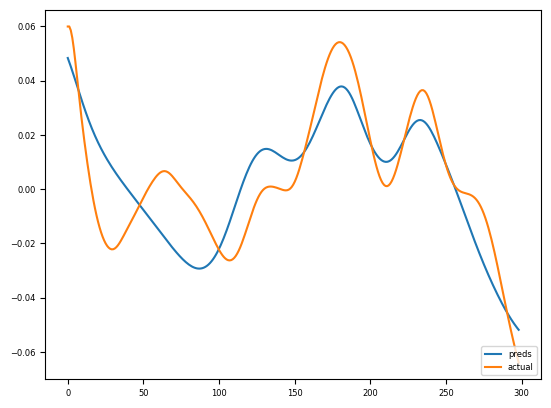

In [90]:
p_area=[pred[:100].mean() for pred in preds]
a_area=[act[:100].mean() for act in actual]


plt.plot(p_area)
plt.plot(a_area)
plt.legend(["preds", "actual"], loc ="lower right")
plt.show()

In [ ]:
# fig, ax =plt.subplots(1,2)

# sns.heatmap(weights_initial[0:10,0:10], ax=ax[0])
# sns.heatmap(rnn_model.J.detach().cpu().numpy()[0:10,0:10], ax=ax[1])

# plt.show()

In [ ]:
# sim={'RNN':,
#      J:, 
#      regions:,
#      params:}

# Compute CURBD

In [ ]:
# def computeCURBD(sim):
#     """
#     function [CURBD,CURBDLabels] = computeCURBD(varargin)
#     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     %
#     % Performs Current-Based Decomposition (CURBD) of multi-region data. Ref:
#     %
#     % Perich MG et al. Inferring brain-wide interactions using data-constrained
#     % recurrent neural network models. bioRxiv. DOI:
#     %
#     % Two input options:
#     %   1) out = computeCURBD(model, params)
#     %       Pass in the output struct of trainMultiRegionRNN and it will do the
#     %       current decomposition. Note that regions has to be defined.
#     %
#     %   2) out = computeCURBD(RNN, J, regions, params)
#     %       Only needs the RNN activity, region info, and J matrix
#     %
#     %   Only parameter right now is current_type, to isolate excitatory or
#     %   inhibitory currents.
#     %
#     % OUTPUTS:
#     %   CURBD: M x M cell array containing the decomposition for M regions.
#     %       Target regions are in rows and source regions are in columns.
#     %   CURBDLabels: M x M cell array with string labels for each current
#     %
#     %
#     % Written by Matthew G. Perich. Updated December 2020.
#     %
#     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     """
#     current_type = 'all'  # 'excitatory', 'inhibitory', or 'all'
#     RNN = sim['RNN']
#     J = sim['J'].copy()
#     regions = sim['regions']

#     if regions is None:
#         raise ValueError("regions not specified")

#     if current_type == 'excitatory':  # take only positive J weights
#         J[J < 0] = 0
#     elif current_type == 'inhibitory':  # take only negative J weights
#         J[J > 0] = 0
#     elif current_type == 'all':
#         pass
#     else:
#         raise ValueError("Unknown current type: {}".format(current_type))

#     nRegions = regions.shape[0]

#     # loop along all bidirectional pairs of regions
#     CURBD = np.empty((nRegions, nRegions), dtype=np.object)
#     CURBDLabels = np.empty((nRegions, nRegions), dtype=np.object)

#     for idx_trg in range(nRegions):
#         in_trg = regions[idx_trg, 1]
#         lab_trg = regions[idx_trg, 0]
#         for idx_src in range(nRegions):
#             in_src = regions[idx_src, 1]
#             lab_src = regions[idx_src, 0]
#             sub_J = J[in_trg, :][:, in_src]
#             CURBD[idx_trg, idx_src] = sub_J.dot(RNN[in_src, :])
#             CURBDLabels[idx_trg, idx_src] = "{} to {}".format(lab_src,
#                                                               lab_trg)
#     return (CURBD, CURBDLabels)

In [ ]:
"""class for fixed point analysis"""

import torch
import torch.nn.functional as F
from torch.autograd import Variable


class FixedPoint(object):
    def __init__(self, model, device, gamma=0.01, speed_tor=1e-06, max_epochs=200000,
                 lr_decay_epoch=10000):
        self.model = model
        self.device = device
        self.gamma = gamma
        self.speed_tor = speed_tor
        self.max_epochs = max_epochs
        self.lr_decay_epoch = lr_decay_epoch

        self.model.eval()

    def calc_speed(self, hidden_activated, const_signal):
        input_signal = const_signal.permute(1, 0, 2)
        pre_activates = self.model.w_hh(hidden_activated)
        activated = torch.tanh(pre_activates)

        speed = torch.norm(activated - hidden_activated)

        return speed

    def find_fixed_point(self, init_hidden, const_signal, view=False):
        new_hidden = init_hidden.clone()
        gamma = self.gamma
        result_ok = True
        i = 0
        while True:
            hidden_activated = Variable(new_hidden).to(self.device)
            hidden_activated.requires_grad = True
            speed = self.calc_speed(hidden_activated, const_signal)
            if view and i % 1000 == 0:
                print(f'epoch: {i}, speed={speed.item()}')
            if speed.item() < self.speed_tor:
                print(f'epoch: {i}, speed={speed.item()}')
                break
            speed.backward()
            if i % self.lr_decay_epoch == 0 and i > 0:
                gamma *= 0.5
            if i == self.max_epochs:
                print(f'forcibly finished. speed={speed.item()}')
                result_ok = False
                break
            i += 1

            new_hidden = hidden_activated - gamma * hidden_activated.grad

        fixed_point = new_hidden[0, 0]
        return fixed_point, result_ok

    def calc_jacobian(self, fixed_point, const_signal_tensor):
        fixed_point = torch.unsqueeze(fixed_point, dim=1)
        fixed_point = Variable(fixed_point).to(self.device)
        fixed_point.requires_grad = True
        input_signal = const_signal_tensor.permute(1, 0, 2)
        w_hh = self.model.w_hh.weight
        w_hh.requires_grad = False
        w_hh = w_hh.to(self.device)
        pre_activates = torch.unsqueeze(self.model.w_in(input_signal[0])[0], dim=1) + \
                        w_hh @ fixed_point + torch.unsqueeze(self.model.w_hh.bias, dim=1)

        if self.model.activation == 'relu':
            activated = F.relu(pre_activates)
        else:
            activated = torch.tanh(pre_activates)

        jacobian = torch.zeros(self.model.n_hid, self.model.n_hid)
        for i in range(self.model.n_hid):
            output = torch.zeros(self.model.n_hid, 1).to(self.device)
            output[i] = 1.
            jacobian[:, i:i + 1] = torch.autograd.grad(activated, fixed_point, grad_outputs=output, retain_graph=True)[
                0]

        jacobian = jacobian.numpy().T

        return jacobian

In [ ]:
import matplotlib
import numpy as np
import torch

matplotlib.use('Agg')

# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# os.makedirs('figures', exist_ok=True)

freq_range = 51
time_length = 40

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CTRNN(g=g,
              tauRNN=tauWN,
              dtRNN=dtRNN,
              input_units=number_units,
              output_units=number_units).to(device)

checkpoint = torch.load('checkpoint.t7')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']


analyzer = FixedPoint(model=model, device=device, max_epochs=1)

# hidden_list_list = np.zeros([30 * time_length, model.n_hid])
# fixed_point_list = np.zeros([15, model.n_hid])
# i = 0
    # while i < 15:
    #     freq = np.random.randint(10, freq_range + 1)
    #     const_signal = np.repeat(freq / freq_range + 0.25, time_length)
    #     const_signal = np.expand_dims(const_signal, axis=1)
    #     const_signal_tensor = torch.from_numpy(np.array([const_signal]))

    #     hidden = torch.zeros(1, 200)
    #     hidden = hidden.to(device)
    #     const_signal_tensor = const_signal_tensor.float().to(device)
    #     with torch.no_grad():
    #         hidden_list, _, _ = model(const_signal_tensor, hidden)

    #     fixed_point, result_ok = analyzer.find_fixed_point(torch.unsqueeze(hidden_list[:, 20, :], dim=0).to(device),
    #                                                        const_signal_tensor)
    #     if not result_ok:
    #         continue

    #     hidden_list_list[i * time_length:(i + 1) * time_length, ...] = hidden_list.cpu().numpy()[:, ...]
    #     fixed_point_list[i] = fixed_point.detach().cpu().numpy()
    #     i += 1







#     pca = PCA(n_components=3)
#     pca.fit(hidden_list_list)

#     fig = plt.figure()
#     ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=45, azim=134)

#     ax.set_xlabel('PC1')
#     ax.set_ylabel('PC2')
#     ax.set_zlabel('PC3')

#     print(hidden_list_list.shape)
#     print(fixed_point_list.shape)
#     pc_trajectory = pca.transform(hidden_list_list)
#     pc_fixed_point = pca.transform(fixed_point_list)

#     for i in range(15):
#         ax.plot(pc_trajectory.T[0, i * time_length:(i + 1) * time_length],
#                 pc_trajectory.T[1, i * time_length:(i + 1) * time_length],
#                 pc_trajectory.T[2, i * time_length:(i + 1) * time_length], color='royalblue')
#     ax.scatter(pc_fixed_point.T[0], pc_fixed_point.T[1], pc_fixed_point.T[2], color='red', marker='x')
#     plt.title('trajectory')
#     plt.savefig(f'figures/trajectory_{activation}.png', dpi=100)


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser(description='PyTorch RNN training')
#     parser.add_argument('--activation', type=str, default='tanh')
#     args = parser.parse_args()
#     # print(args)
#     main(args.activation)

In [ ]:
list(model.parameters())

<module 'ntpath' from 'c:\\Users\\Andrew\\AppData\\Local\\Programs\\Python\\Python38\\lib\\ntpath.py'>